## Imports y datasets

Importamos librerias y funciones a utilizar.

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

import pickle

Seteamos una semilla para que los resultados sean reproducibles.

In [72]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE) 

Importamos los datasets a utilizar y los guardamos en variables.

In [73]:
test = pd.read_csv('Datasets/test_encoded.csv').copy()
train = pd.read_csv('Datasets/train_encoded.csv').copy()
original = pd.read_csv('Datasets/hotels_procesado.csv')
original_test = pd.read_csv('Datasets/hotels_test.csv')

In [74]:
train.drop(columns=['Unnamed: 0'], inplace=True)
test.drop(columns=['Unnamed: 0'], inplace=True)

## Normalizacion y split de datasets

Normalizamos los datos a utilizar.

In [75]:
stand_scaler = StandardScaler()
train = stand_scaler.fit_transform(train)
test = stand_scaler.transform(test)

Separamos los datos en train y test cvon una proporcion de 70/30

In [76]:
x = train.copy()
y = original['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=RANDOM_STATE) #semilla

In [77]:
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 37192
# Datos Prueba: 15940
% Positivos Entrenamiento: 50.863
% Positivos Prueba: 50.866


Ahora vamos a variar parámetros creando 3 modelos distintos para ver cual da mejores resultados.

## Modelo 1

Seteamos la cantidad de capas, neuronas por capa y funcion de activacion.

In [78]:
cant_clases = len(np.unique(y_train))
cant_inputs = len(train[0])

modelo_1 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[cant_inputs]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

Vamos a utilizar EarlyStopping como funcion de regularizacion para evitar el overfitting.

In [79]:
es = EarlyStopping(monitor='val_loss', patience=5) 

Acá podemos ver un resumen del modelo.

In [80]:
modelo_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                10944     
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________


Seteamos parámetros para este primer modelo: cantidad de epochs y optimizador a utilizar, y luego entrenamos el modelo

In [81]:
epochs = 256

In [82]:
modelo_1.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
    )

history = modelo_1.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=1, validation_data = (x_test, y_test), callbacks=[es])

Epoch 1/256
582/582 [==============================] - 4s 4ms/step - loss: 0.4202 - accuracy: 0.7879 - val_loss: 0.3614 - val_accuracy: 0.8257
Epoch 2/256
582/582 [==============================] - 2s 3ms/step - loss: 0.3304 - accuracy: 0.8402 - val_loss: 0.3405 - val_accuracy: 0.8391
Epoch 3/256
582/582 [==============================] - 2s 3ms/step - loss: 0.3062 - accuracy: 0.8543 - val_loss: 0.3346 - val_accuracy: 0.8440
Epoch 4/256
582/582 [==============================] - 2s 3ms/step - loss: 0.2900 - accuracy: 0.8649 - val_loss: 0.3299 - val_accuracy: 0.8446
Epoch 5/256
582/582 [==============================] - 1s 3ms/step - loss: 0.2769 - accuracy: 0.8716 - val_loss: 0.3352 - val_accuracy: 0.8394
Epoch 6/256
582/582 [==============================] - 2s 3ms/step - loss: 0.2661 - accuracy: 0.8767 - val_loss: 0.3448 - val_accuracy: 0.8405
Epoch 7/256
582/582 [==============================] - 2s 3ms/step - loss: 0.2554 - accuracy: 0.8838 - val_loss: 0.3395 - val_accuracy: 0.8453

En el siguiente gráfico podemos ver como varía el error por epoch:

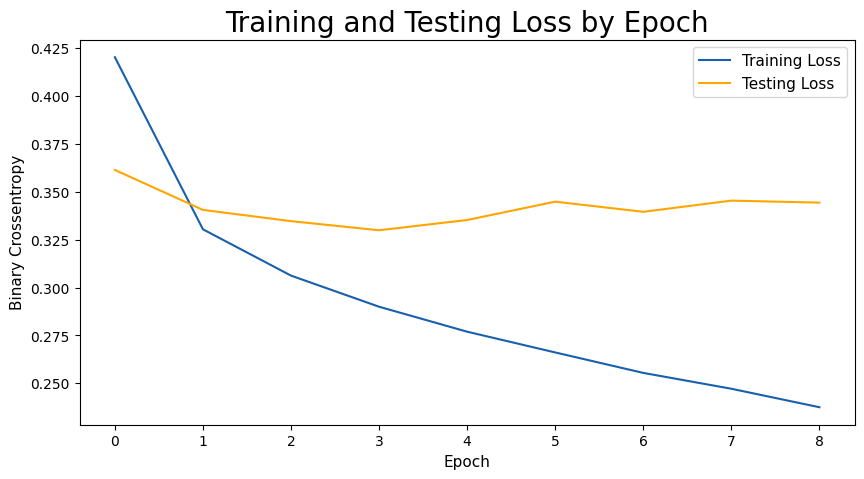

In [83]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 11)
plt.ylabel('Binary Crossentropy', fontsize = 11)
plt.legend(fontsize = 11)

Acá podemos ver como varía el accuracy por epoch:

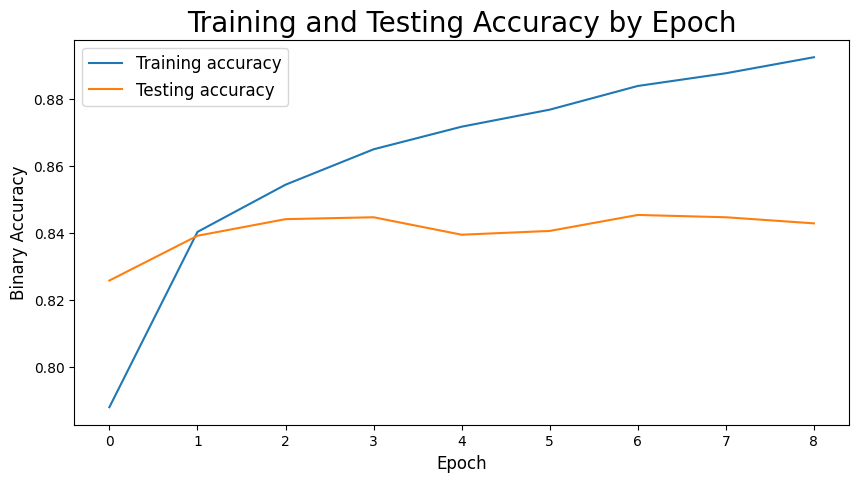

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Testing accuracy')
plt.title('Training and Testing Accuracy by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Binary Accuracy', fontsize = 12)
plt.legend(fontsize = 12)

En el siguiente gráfico se puede ver el area bajo la curva:

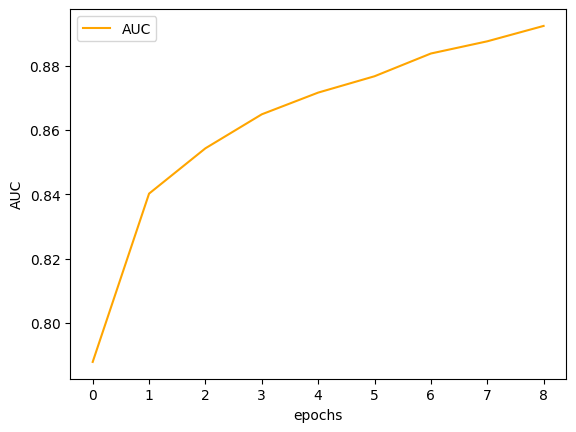

In [85]:
plt.plot(history.history['accuracy'], color='orange', label='AUC')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

In [86]:
train_score = modelo_1.evaluate(x_train,
                       y_train,
                       verbose=1)
test_score = modelo_1.evaluate(x_test,
                       y_test,
                       verbose=1)
labels = modelo_1.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

499/499 [==============================] - 1s 3ms/step - loss: 0.3443 - accuracy: 0.8428

Training Accuracy: 0.9050602316856384
Testing Accuracy: 0.8427854180335999


In [87]:
y_pred = modelo_1.predict(x_test)

499/499 [==============================] - 1s 1ms/step


In [88]:
y_pred_binario = np.where(y_pred > 0.3851, 1, 0)

accuracy = accuracy_score(y_test, y_pred_binario)
recall = recall_score(y_test, y_pred_binario)
f1 = f1_score(y_test, y_pred_binario,)
precision = precision_score(y_test, y_pred_binario)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8387703889585947
Recall: 0.8947952639368525
Precision: 0.8086268390548372
f1 score: 0.8495316159250587


In [89]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred_binario))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      7832
           1       0.81      0.89      0.85      8108

    accuracy                           0.84     15940
   macro avg       0.84      0.84      0.84     15940
weighted avg       0.84      0.84      0.84     15940



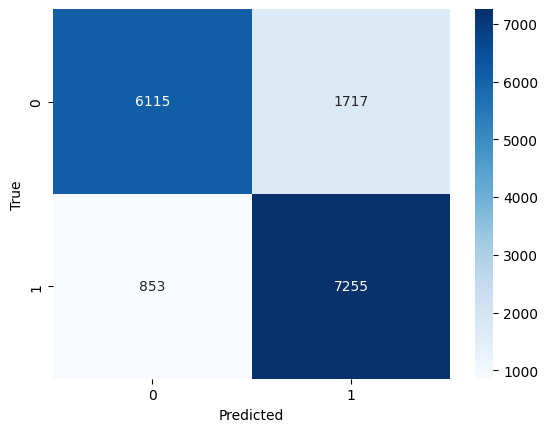

In [90]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_binario)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Modelo 2

Seteamos la cantidad de capas, neuronas por capa y funcion de activacion.

In [91]:
cant_clases = len(np.unique(y_train))
cant_inputs = len(train[0])

modelo_2 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[cant_inputs]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

Vamos a utilizar EarlyStopping como funcion de regularizacion para evitar el overfitting.

In [92]:
es = EarlyStopping(monitor='val_loss', patience=5) 

Acá podemos ver un resumen del modelo.

In [93]:
modelo_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                10944     
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________


Seteamos parámetros para este primer modelo: cantidad de epochs y optimizador a utilizar, y luego entrenamos el modelo

In [94]:
epochs = 100

In [95]:
modelo_2.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', keras.metrics.Precision()] 
    )

history = modelo_2.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=1, validation_data = (x_test, y_test), callbacks=[es])

Epoch 1/100
582/582 [==============================] - 3s 4ms/step - loss: 0.5883 - accuracy: 0.6647 - precision_1: 0.6806 - val_loss: 0.5081 - val_accuracy: 0.7320 - val_precision_1: 0.7445
Epoch 2/100
582/582 [==============================] - 2s 3ms/step - loss: 0.4649 - accuracy: 0.7613 - precision_1: 0.7826 - val_loss: 0.4409 - val_accuracy: 0.7811 - val_precision_1: 0.8114
Epoch 3/100
582/582 [==============================] - 2s 3ms/step - loss: 0.4178 - accuracy: 0.7943 - precision_1: 0.8079 - val_loss: 0.4137 - val_accuracy: 0.7989 - val_precision_1: 0.8147
Epoch 4/100
582/582 [==============================] - 2s 3ms/step - loss: 0.3953 - accuracy: 0.8092 - precision_1: 0.8172 - val_loss: 0.3996 - val_accuracy: 0.8082 - val_precision_1: 0.8138
Epoch 5/100
582/582 [==============================] - 2s 4ms/step - loss: 0.3811 - accuracy: 0.8153 - precision_1: 0.8203 - val_loss: 0.3909 - val_accuracy: 0.8127 - val_precision_1: 0.8105
Epoch 6/100
582/582 [========================

KeyboardInterrupt: 

En el siguiente gráfico podemos ver como varía el error por epoch:

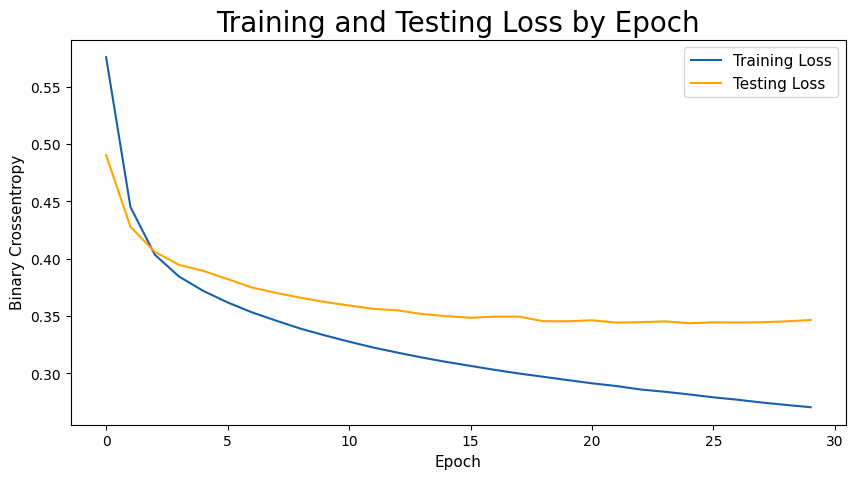

In [ ]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 11)
plt.ylabel('Binary Crossentropy', fontsize = 11)
plt.legend(fontsize = 11)

Acá podemos ver como varía el accuracy por epoch:

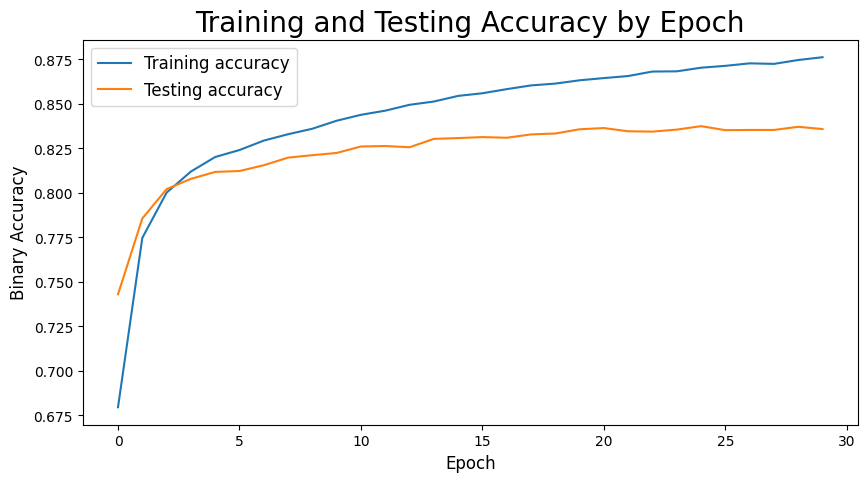

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Testing accuracy')
plt.title('Training and Testing Accuracy by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Binary Accuracy', fontsize = 12)
plt.legend(fontsize = 12)

En el siguiente gráfico se puede ver el area bajo la curva:

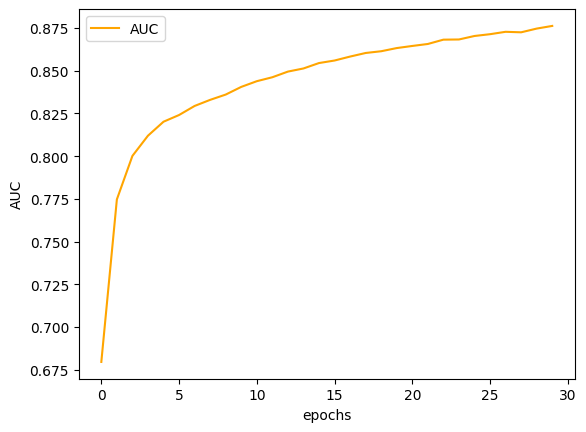

In [ ]:
plt.plot(history.history['accuracy'], color='orange', label='AUC')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

In [ ]:
train_score = modelo_2.evaluate(x_train,
                       y_train,
                       verbose=1)
test_score = modelo_2.evaluate(x_test,
                       y_test,
                       verbose=1)
labels = modelo_2.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

499/499 [==============================] - 1s 2ms/step - loss: 0.3466 - accuracy: 0.8359 - precision: 0.8331

Training Accuracy: 0.8798935413360596
Testing Accuracy: 0.8358845710754395


In [ ]:
y_pred = modelo_2.predict(x_test)

499/499 [==============================] - 1s 1ms/step


In [ ]:
y_pred_binario = np.where(y_pred > 0.3851, 1, 0)

accuracy = accuracy_score(y_test, y_pred_binario)
recall = recall_score(y_test, y_pred_binario)
f1 = f1_score(y_test, y_pred_binario,)
precision = precision_score(y_test, y_pred_binario)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8322459222082811
Recall: 0.8952886038480513
Precision: 0.7990973139586085
f1 score: 0.8444625407166124


In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred_binario))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      7832
           1       0.80      0.90      0.84      8108

    accuracy                           0.83     15940
   macro avg       0.84      0.83      0.83     15940
weighted avg       0.84      0.83      0.83     15940



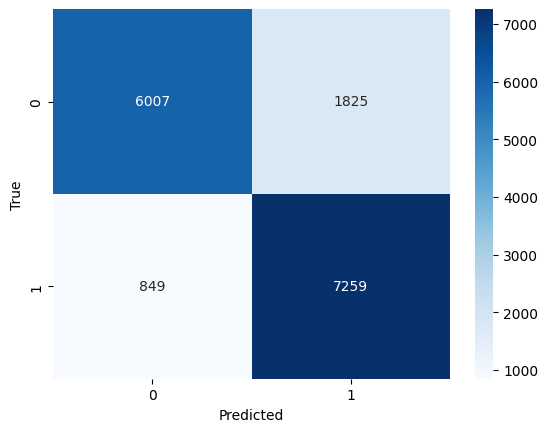

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_binario)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Modelo 3

Seteamos la cantidad de capas, neuronas por capa y funcion de activacion.

In [ ]:
cant_clases = len(np.unique(y_train))
cant_inputs = len(train[0])

modelo_3 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[cant_inputs]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

Vamos a utilizar EarlyStopping como funcion de regularizacion para evitar el overfitting.

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=5) 

Acá podemos ver un resumen del modelo.

In [ ]:
modelo_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                10944     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________


Seteamos parámetros para este primer modelo: cantidad de epochs y optimizador a utilizar, y luego entrenamos el modelo

In [ ]:
epochs = 50

In [96]:
modelo_3.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
    )

history = modelo_3.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=1, validation_data = (x_test, y_test), callbacks=[es])

Epoch 1/100
582/582 [==============================] - 3s 3ms/step - loss: 0.2237 - accuracy: 0.8959 - val_loss: 0.3765 - val_accuracy: 0.8505
Epoch 2/100
582/582 [==============================] - 2s 3ms/step - loss: 0.2105 - accuracy: 0.9040 - val_loss: 0.3871 - val_accuracy: 0.8496
Epoch 3/100
582/582 [==============================] - 2s 3ms/step - loss: 0.2042 - accuracy: 0.9073 - val_loss: 0.3980 - val_accuracy: 0.8495
Epoch 4/100
582/582 [==============================] - 2s 3ms/step - loss: 0.1995 - accuracy: 0.9112 - val_loss: 0.4063 - val_accuracy: 0.8479
Epoch 5/100
582/582 [==============================] - 2s 3ms/step - loss: 0.1957 - accuracy: 0.9130 - val_loss: 0.4246 - val_accuracy: 0.8476
Epoch 6/100
582/582 [==============================] - 2s 3ms/step - loss: 0.1922 - accuracy: 0.9150 - val_loss: 0.4353 - val_accuracy: 0.8492


En el siguiente gráfico podemos ver como varía el error por epoch:

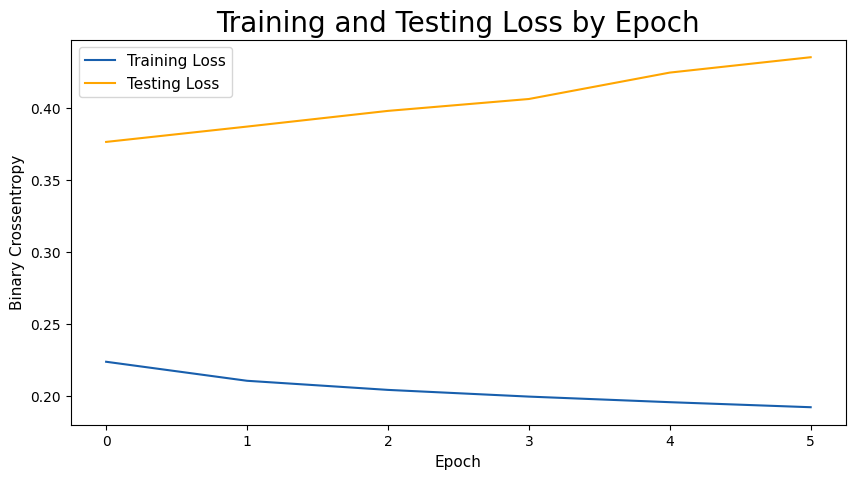

In [97]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 11)
plt.ylabel('Binary Crossentropy', fontsize = 11)
plt.legend(fontsize = 11)

Acá podemos ver como varía el accuracy por epoch:

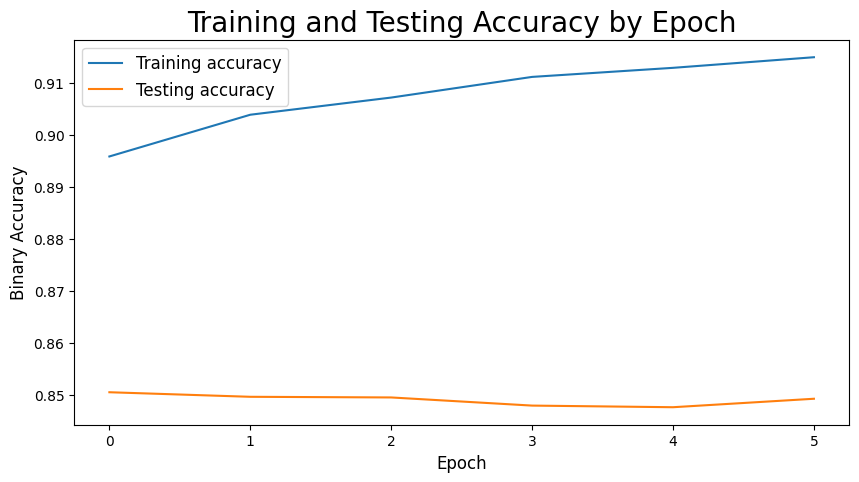

In [98]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Testing accuracy')
plt.title('Training and Testing Accuracy by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Binary Accuracy', fontsize = 12)
plt.legend(fontsize = 12)

En el siguiente gráfico se puede ver el area bajo la curva:

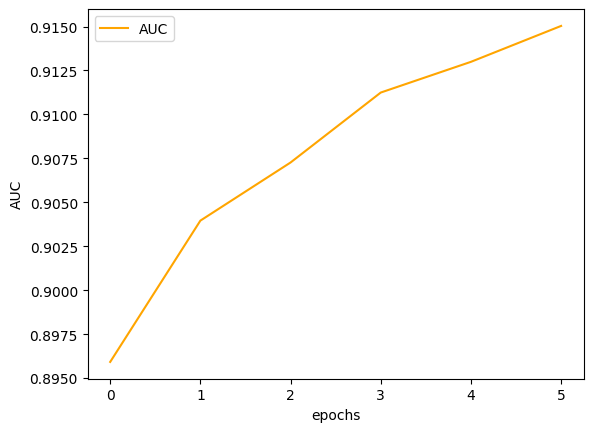

In [99]:
plt.plot(history.history['accuracy'], color='orange', label='AUC')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

In [100]:
train_score = modelo_3.evaluate(x_train,
                       y_train,
                       verbose=1)
test_score = modelo_3.evaluate(x_test,
                       y_test,
                       verbose=1)
labels = modelo_3.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

499/499 [==============================] - 1s 1ms/step - loss: 0.4353 - accuracy: 0.8492

Training Accuracy: 0.9194181561470032
Testing Accuracy: 0.8492471575737


In [101]:
y_pred = modelo_3.predict(x_test)

499/499 [==============================] - 1s 1ms/step


In [102]:
y_pred_binario = np.where(y_pred > 0.3851, 1, 0)

accuracy = accuracy_score(y_test, y_pred_binario)
recall = recall_score(y_test, y_pred_binario)
f1 = f1_score(y_test, y_pred_binario,)
precision = precision_score(y_test, y_pred_binario)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8468632371392723
Recall: 0.8882585101134681
Precision: 0.8243104040288428
f1 score: 0.8550905313149303


In [103]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred_binario))

              precision    recall  f1-score   support

           0       0.87      0.80      0.84      7832
           1       0.82      0.89      0.86      8108

    accuracy                           0.85     15940
   macro avg       0.85      0.85      0.85     15940
weighted avg       0.85      0.85      0.85     15940



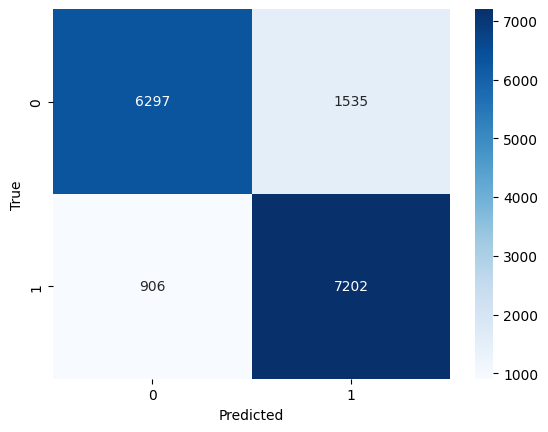

In [104]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_binario)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Submission

El mejor modelo es el modelo 3 con un f1 score de 0.855 asique guardamos este modelo y usamos su prediccion para kaggle.

In [106]:
pickle.dump(modelo_3, open('neural_network_grupo29.pickle', 'wb'))

In [107]:
X_submission = test
y_pred_test = modelo_3.predict(X_submission)
y_pred_test_binario = np.where(y_pred_test > 0.3851, 1, 0)

830/830 [==============================] - 1s 1ms/step


In [108]:
df_submission = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_binario.flatten()})
df_submission.to_csv('nn01.csv', index=False)